In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import tree

import SweetSpotPrediction as ssp

# 03 Exploration of models
Try out a few models see which one works
*Note: Run 01 to build the .csv files needed*

In [2]:
df = pd.read_csv('ClassificationData.csv')

df.head()

,Unnamed: 0,XPos,YPos,Thickness,AvgNTG,AvgPerm,AvgPoro,NetPerm,SweetSpot,WellPresent
0,172,452050.0,6780950.0,2.535993,0.487495,522.118372,0.161892,1316.895444,1,0
1,173,452050.0,6781000.0,5.272397,0.505895,672.209589,0.158925,2556.454528,1,0
2,174,452050.0,6781050.0,5.555539,0.607166,708.849096,0.166871,3012.225791,0,0
3,175,452050.0,6781100.0,4.928132,0.740983,605.196035,0.160425,2504.174453,0,0
4,176,452050.0,6781150.0,4.036606,0.799833,319.160790,0.141114,1195.540589,0,0


In [3]:
features = [
    #'XPos', # propbably dont want these as features
    #'YPos', # propbably dont want these as features
    'Thickness',
    'AvgNTG',
    'AvgPerm',
    'AvgPoro', # removing this increases Gauss with a very small fraction (0.260 to 0.266)
    'NetPerm',
    #'PermTimesPoro',
]

label_clf = 'SweetSpot' # 'WellPresent' 
label_reg = 'WellProbability'
lable_swt = 'SweetSpot'


In [4]:
df.dropna(inplace=True)

In [5]:
X_train, X_, y_train, y_ = train_test_split(df[features], df[label_clf], test_size=0.33, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size=0.50, random_state=42)



# Normalization and other preprocessing

In [6]:
preprocessing = StandardScaler()
X_train = preprocessing.fit_transform(X_train)
#X_test = preprocessing.transform(X_test)
X_val = preprocessing.transform(X_val)
X_train[:5]

array([[ 1.65014232,  0.18231105, -0.16373121,  0.7286982 ,  0.3948424 ],
       [ 1.04073621, -0.32438038, -0.1754074 ,  0.31141331,  2.7195599 ],
       [-0.22082252, -0.02677682, -0.37602856, -0.93338002, -0.05879958],
       [ 0.04493207, -1.23242817,  1.86304624,  0.09908652, -0.96789496],
       [ 0.4751954 , -0.98980224,  0.27746817,  0.04990199,  0.9685945 ]])

In [7]:
#from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
    
classifiers = [
    AdaBoostClassifier(n_estimators=200),
    DecisionTreeClassifier(class_weight='balanced'),
    GradientBoostingClassifier(),
    GaussianNB(),
    KNeighborsClassifier(3),
    #NuSVC(probability=True),
    LinearDiscriminantAnalysis(),
    MLPClassifier(hidden_layer_sizes=(200,4),max_iter=1000),
    QuadraticDiscriminantAnalysis(),
    RandomForestClassifier(class_weight='balanced',n_estimators=200),
    SVC(kernel="rbf", C=0.25, probability=True,class_weight='balanced'),

    ]

In [8]:
for index, clf in enumerate(classifiers):
    print(f"Model {index}: {clf}")
    clf.fit(X_train, y_train)
    y_pred_val = clf.predict(X_val)
    ssp.ReportMetrics(clf, X_train, X_val, y_train, y_val, y_pred_val)
    print(f"-------------------------------------------------------------------")

Model 0: AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=200, random_state=None)
Precision: 0.832
Recall: 0.767
F1: 0.798
-------------------------------------------------------------------
Model 1: DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Precision: 0.827
Recall: 0.810
F1: 0.818
-------------------------------------------------------------------
Model 2: GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples

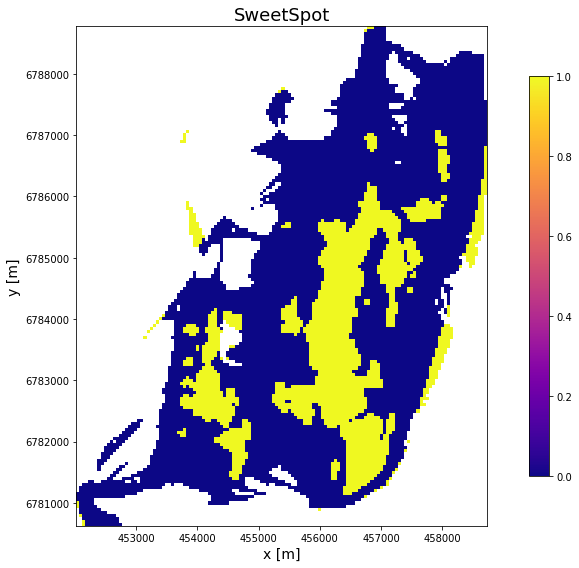

In [9]:
ssp.plot_map(df, 'SweetSpot',dtype='cat')

In [15]:
bestModel = classifiers[8]
#ssp.plot_feature_importances(bestModel,features)

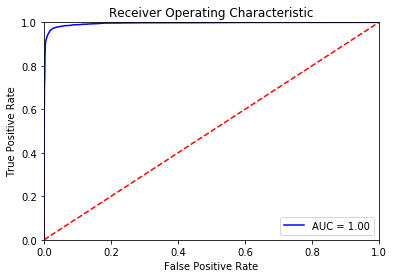

In [16]:
from sklearn.metrics import roc_curve, auc
df['prediction_prob'] = bestModel.predict_proba(preprocessing.transform(df[features]))[:,1]

fpr, tpr, threshold = roc_curve(df[label_clf], df['prediction_prob'] )

roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

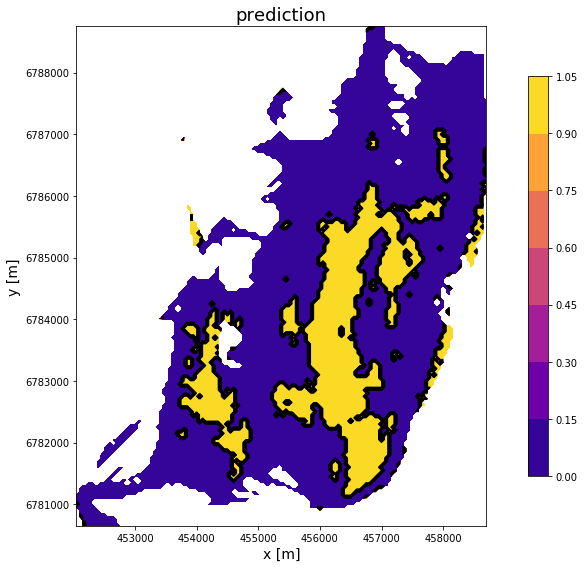

In [17]:
df['prediction'] = bestModel.predict(preprocessing.transform(df[features]))
ssp.plot_map(df, 'prediction')


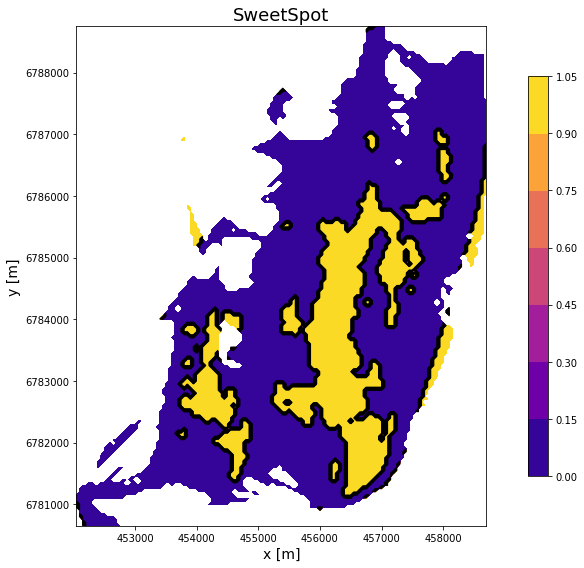

In [19]:
ssp.plot_map(df, label_clf)

In [18]:
from sklearn.utils.class_weight import compute_sample_weight
from sklearn import metrics

weights_train = compute_sample_weight(class_weight='balanced', y=y_train)
weights_test = compute_sample_weight(class_weight='balanced', y=y_val)

print("Weighted accuracy on training set: {:.3f}".format(bestModel.score(X_train, y_train, sample_weight=weights_train)))
print("Weighted accuracy on test set: {:.3f}".format(bestModel.score(X_val, y_val,weights_test)))

Weighted accuracy on training set: 1.000
Weighted accuracy on test set: 0.902


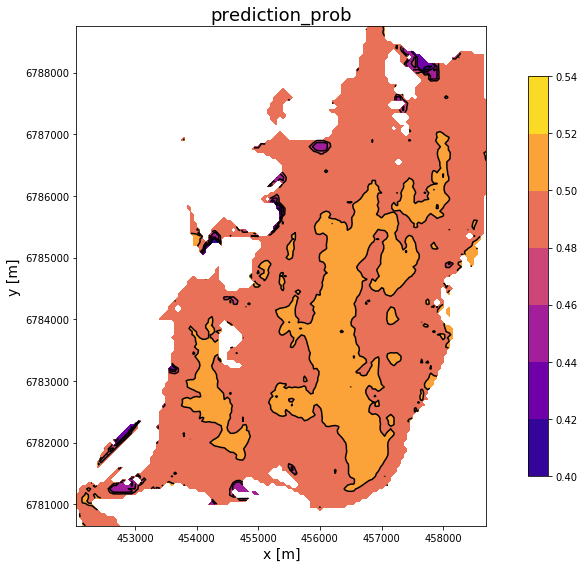

In [14]:
ssp.plot_map(df, 'prediction_prob')

# <a href="02 Base Model.ipynb">Previous</a> <a href="04 Classification model.ipynb">Next</a> Notebook